In [1]:
!nvidia-smi

Sat Sep 30 06:12:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

- Encoder & decoder both gets one-hot vector with 0.5, 0.5

In [2]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import numpy as np
from tqdm import tqdm
from tqdm.notebook import trange, tqdm

In [3]:
# check if cuda is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
bs = 128
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 204682439.92it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 29266898.73it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 76712825.94it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21333178.91it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [17]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()

        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc40 = nn.Linear(x_dim, h_dim2)
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        h0 = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h0))
        temp0 = self.fc31(h)
        temp1 = self.fc32(h)
        return self.fc31(h), self.fc32(h) # mu, log_var

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample

    def decoder(self, z, one_hot):
        h00 = F.relu(self.fc40(one_hot))
        h = F.relu(self.fc4(z))
        h = torch.add(h, h00)
        h = F.relu(self.fc5(h))
        h = F.sigmoid(self.fc6(h))
        return h

    def forward(self, x, one_hot):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z, one_hot.view(-1, 784)), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [18]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc40): Linear(in_features=784, out_features=256, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [26]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [30]:
def train(epoch):
    vae.train()
    train_loss = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, label) in enumerate(pbar):

        data = data.float().cuda()

        # Please check "One-hot Label logic sample check" section given at bottom to understand this logic
        label_one_hot = F.one_hot(label, 10).float().cuda()
        indices = torch.nonzero(label_one_hot == 1, as_tuple=True)
        zero_tensor = torch.zeros_like(data)
        for batch_num, index in enumerate(indices[1]):
            zero_tensor[batch_num, :, :, index] = 0.5
            if index == 9:
                zero_tensor[batch_num, :, :, 0] = 0.5
            else:
                zero_tensor[batch_num, :, :, index+1] = 0.5
        zero_tensor = zero_tensor.float().cuda()
        new_data = torch.add(data, zero_tensor)

        optimizer.zero_grad()

        recon_batch, mu, log_var = vae(new_data, zero_tensor)
        loss = loss_function(recon_batch, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        pbar.set_description(desc=f'Epoch = {epoch} Loss={loss.item()/len(data) :0.4f} Batch={batch_idx}')

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [31]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data = data.float().cuda()

            # Please check "One-hot Label logic sample check" section given at bottom to understand this logic
            label_one_hot = F.one_hot(label, 10).float().cuda()
            indices = torch.nonzero(label_one_hot == 1, as_tuple=True)
            zero_tensor = torch.zeros_like(data)
            for batch_num, index in enumerate(indices[1]):
                zero_tensor[batch_num, :, :, index] = 0.5
                if index == 9:
                    zero_tensor[batch_num, :, :, 0] = 0.5
                else:
                    zero_tensor[batch_num, :, :, index+1] = 0.5
            zero_tensor = zero_tensor.float().cuda()
            new_data = torch.add(data, zero_tensor)

            recon, mu, log_var = vae(new_data, zero_tensor)

            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()

    test_loss /= len(test_loader.dataset)
    print('====>     Test loss: {:.4f}'.format(test_loss))

In [49]:
for epoch in range(1, 51):
    train(epoch)
    test()

  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 1 Average loss: 129.7944
====>     Test loss: 130.3004


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 2 Average loss: 129.5154
====>     Test loss: 129.9467


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 3 Average loss: 129.2877
====>     Test loss: 129.8686


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 4 Average loss: 129.0386
====>     Test loss: 129.5593


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 5 Average loss: 128.8013
====>     Test loss: 129.4598


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 6 Average loss: 128.5591
====>     Test loss: 129.5235


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 7 Average loss: 128.3909
====>     Test loss: 129.2402


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 8 Average loss: 128.2047
====>     Test loss: 129.5291


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 9 Average loss: 128.0052
====>     Test loss: 129.0103


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 10 Average loss: 127.8290
====>     Test loss: 128.9567


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 11 Average loss: 127.7016
====>     Test loss: 128.7811


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 12 Average loss: 127.4883
====>     Test loss: 128.8227


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 13 Average loss: 127.3812
====>     Test loss: 128.6708


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 14 Average loss: 127.2379
====>     Test loss: 128.7872


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 15 Average loss: 127.1440
====>     Test loss: 128.4009


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 16 Average loss: 126.9308
====>     Test loss: 128.5346


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 17 Average loss: 126.8775
====>     Test loss: 128.2495


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 18 Average loss: 126.7369
====>     Test loss: 128.1527


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 19 Average loss: 126.5641
====>     Test loss: 128.4613


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 20 Average loss: 126.5139
====>     Test loss: 127.9949


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 21 Average loss: 126.3365
====>     Test loss: 128.2339


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 22 Average loss: 126.2382
====>     Test loss: 128.0064


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 23 Average loss: 126.1652
====>     Test loss: 127.7938


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 24 Average loss: 125.9854
====>     Test loss: 128.2566


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 25 Average loss: 125.9780
====>     Test loss: 127.9524


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 26 Average loss: 125.7966
====>     Test loss: 127.7759


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 27 Average loss: 125.7260
====>     Test loss: 127.8345


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 28 Average loss: 125.6965
====>     Test loss: 127.8932


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 29 Average loss: 125.5333
====>     Test loss: 127.7944


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 30 Average loss: 125.4480
====>     Test loss: 127.8246


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 31 Average loss: 125.3645
====>     Test loss: 127.6437


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 32 Average loss: 125.2974
====>     Test loss: 127.7405


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 33 Average loss: 125.1939
====>     Test loss: 127.7964


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 34 Average loss: 125.0576
====>     Test loss: 127.7357


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 35 Average loss: 125.0006
====>     Test loss: 127.6074


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 36 Average loss: 124.9334
====>     Test loss: 127.5408


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 37 Average loss: 124.8587
====>     Test loss: 127.8125


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 38 Average loss: 124.8094
====>     Test loss: 127.3912


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 39 Average loss: 124.6381
====>     Test loss: 127.6457


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 40 Average loss: 124.6360
====>     Test loss: 127.5074


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 41 Average loss: 124.5595
====>     Test loss: 127.4871


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 42 Average loss: 124.4869
====>     Test loss: 127.2858


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 43 Average loss: 124.4491
====>     Test loss: 127.4789


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 44 Average loss: 124.3719
====>     Test loss: 127.4605


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 45 Average loss: 124.3334
====>     Test loss: 127.2684


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 46 Average loss: 124.2432
====>     Test loss: 127.3709


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 47 Average loss: 124.2096
====>     Test loss: 127.3843


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 48 Average loss: 124.0459
====>     Test loss: 127.4859


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 49 Average loss: 124.0177
====>     Test loss: 127.7276


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 50 Average loss: 124.0620
====>     Test loss: 127.4213


In [33]:
!mkdir './samples'

mkdir: cannot create directory ‘./samples’: File exists


In [50]:
with torch.no_grad():
    z = torch.randn(64, 2).cuda()
    o = torch.randn(64, 1, 28, 28).cuda()
    o1 = o.view(-1, 784)
    sample = vae.decoder(z, o1).cuda()

    save_image(sample.view(64, 1, 28, 28), './samples/sample_' + '.png')

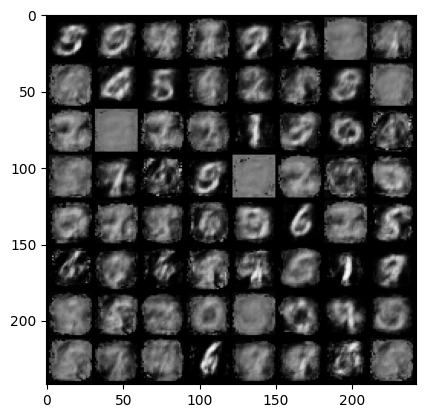

In [51]:
img = plt.imread('/content/samples/sample_.png')
plt.imshow(img)

In [40]:
len(val_loader.dataset)

10000

In [52]:
def validate():
    vae.eval()
    with torch.no_grad():
        i = 0
        for data, label in val_loader:
            i += 1
            if i > 0:
                break

        print(f' Correct   label : {label.tolist()}')
        number_to_image(label.tolist(), '/content/samples/correct_label.png')
        data = data.float().cuda()

        # Please check "One-hot Label logic sample check" section given at bottom to understand this logic
        label_one_hot = F.one_hot(label, 10).float().cuda()
        indices = torch.nonzero(label_one_hot == 1, as_tuple=True)
        zero_tensor = torch.zeros_like(data)
        for batch_num, index in enumerate(indices[1]):
            zero_tensor[batch_num, :, :, index] = 0.5
            if index == 9:
                zero_tensor[batch_num, :, :, 0] = 0.5
            else:
                zero_tensor[batch_num, :, :, index+1] = 0.5
        zero_tensor = zero_tensor.float().cuda()
        new_data = torch.add(data, zero_tensor)

        recon_val, mu_val, log_var_val = vae(new_data, zero_tensor)

        save_image(data, './samples/data_32' + '.png')
        save_image(recon_val.view(32, 1, 28, 28), './samples/pred_32_with_correct_label' + '.png')

        for lab in label:
            if lab == 9:
                lab -= 9
            else:
                lab += 1

        print(f' Modified  label : {label.tolist()}')
        number_to_image(label.tolist(), '/content/samples/modified_label.png')

        # Please check "One-hot Label logic sample check" section given at bottom to understand this logic
        label_one_hot = F.one_hot(label, 10).float().cuda()
        indices = torch.nonzero(label_one_hot == 1, as_tuple=True)
        zero_tensor = torch.zeros_like(data)
        for batch_num, index in enumerate(indices[1]):
            zero_tensor[batch_num, :, :, index] = 0.5
            if index == 9:
                zero_tensor[batch_num, :, :, 0] = 0.5
            else:
                zero_tensor[batch_num, :, :, index+1] = 0.5
        zero_tensor = zero_tensor.float().cuda()
        new_data = torch.add(data, zero_tensor)

        recon_val_wrong, mu_val, log_var_val = vae(new_data, zero_tensor)
        save_image(recon_val_wrong.view(32, 1, 28, 28), './samples/pred_32_with_wrong_label' + '.png')

        input_arr   = np.asarray(Image.open('/content/samples/data_32.png'))
        correct_arr = np.asarray(Image.open('/content/samples/pred_32_with_correct_label.png'))
        wrong_arr   = np.asarray(Image.open('/content/samples/pred_32_with_wrong_label.png'))
        corr_label_arr = np.asarray(Image.open('/content/samples/correct_label.png'))
        mod_label_arr = np.asarray(Image.open('/content/samples/modified_label.png'))
        np_arr = np.stack((input_arr, correct_arr, wrong_arr, corr_label_arr, corr_label_arr, mod_label_arr))
        title_list = ['Original Input', 'Pred with correct labels', 'Pred with modified labels', \
                      'Original Label', 'Original Labels for Pred', 'Modified labels for Pred']

        plt.figure(figsize=(12, 12))
        for i in range(6):
            plt.subplot(2, 3, i + 1)
            plt.imshow(np_arr[i])
            plt.title(title_list[i])
            plt.axis('off')
        plt.show()

 Correct   label : [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1]
 Modified  label : [8, 3, 2, 1, 5, 2, 5, 0, 6, 0, 1, 7, 0, 1, 2, 6, 0, 8, 4, 5, 0, 7, 7, 6, 5, 1, 8, 5, 1, 2, 4, 2]


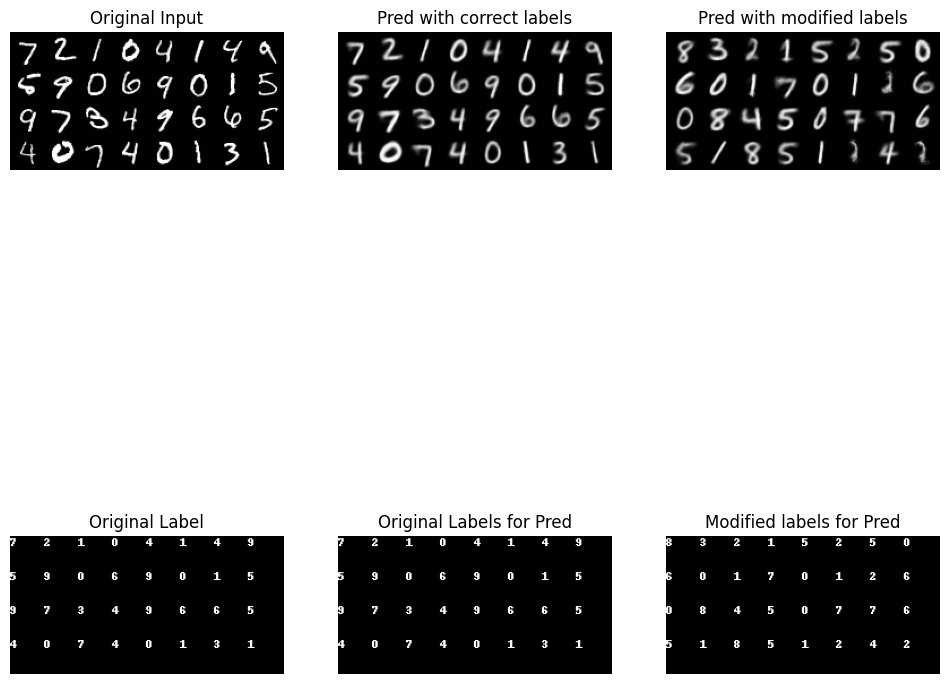

In [53]:
validate()

In [15]:
def number_to_image(num_list, image_save_name):
      # Determine the grid size (e.g., 4x8)
      num_rows = 4
      num_cols = 8
      image_width = 242  # Adjust as needed
      image_height = 122  # Adjust as needed

      # Create a blank image with a white background
      image = Image.new('RGB', (image_width, image_height), color='black')
      draw = ImageDraw.Draw(image)

      # Define the size of each cell in the grid
      cell_width = image_width // num_cols
      cell_height = image_height // num_rows

      # Loop through the numbers and draw them in a grid
      for i, number in enumerate(num_list):
          row = i // num_cols
          col = i % num_cols
          x = col * cell_width
          y = row * cell_height
          text = str(number)
          draw.text((x, y), text, fill='white')

      # Save the image as a PNG file
      image.save(image_save_name)

#### # One-hot Label logic sample check

In [ ]:
# One-hot Label logic sample check


prev_tensor = torch.ones(2, 10, 10)
zero_tensor = torch.zeros(2, 10, 10)

labels_list = [9, 6]
labels = torch.tensor(labels_list)
print(f'labels : {labels}')
label_one_hot = F.one_hot(labels, 10)
print(f'label_one_hot : {label_one_hot}')

indices = torch.nonzero(label_one_hot == 1, as_tuple=True)
print(f' indices are {indices}')
# zero_tensor[:, index] = 0.5
# zero_tensor[:, index+1] = 0.5

for batch_idx, idx in enumerate(indices[1]):
    print(batch_idx, idx)
    zero_tensor[batch_idx, :, idx] = 0.7
    if idx == 9:
        zero_tensor[batch_idx, :, 0] = 0.3
    else:
        zero_tensor[batch_idx, :, idx+1] = 0.3

new_tensor = torch.add(prev_tensor, zero_tensor)
print(f'zero_tensor: {zero_tensor}')
print(f'new_tensor: {new_tensor}')
print(f'new_tensor.shape: {new_tensor.shape}')

labels : tensor([9, 6])
label_one_hot : tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])
 indices are (tensor([0, 1]), tensor([9, 6]))
0 tensor(9)
1 tensor(6)
zero_tensor: tensor([[[0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.7000],
         [0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.7000],
         [0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.7000],
         [0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.7000],
         [0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.7000],
         [0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.7000],
         [0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.7000],
         [0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.000